In [2]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from fiona.crs import from_epsg

from li_dbs import DataBridge
from utils import PHL_CRS, create_point_geometry, reproject_gdf

Read in Data

In [4]:
remediations_buffer = gpd.read_file('../data/remediations_buffer.shp')

In [5]:
with DataBridge.DataBridge() as con:
    sql = '''
    SELECT * FROM
    (
        SELECT 
            EXTRACT(year FROM requested_datetime) year, 
            EXTRACT(month FROM requested_datetime) month, 
            service_name,
            sde.st_minx(SHAPE) X,
            sde.st_miny(SHAPE) y
        FROM
            gis_311.salesforce_cases
        WHERE
            requested_datetime >= TO_DATE('01/JAN/2016','dd/mon/yyyy')
            AND sde.st_minx(SHAPE) != 0
    )
    WHERE 
        month > 3
        AND month < 12
    '''
    three_one_one = pd.read_sql(sql=sql, con=con) \
                      .dropna()

In [ ]:
with DataBridge.DataBridge() as con:
    sql = '''
    SELECT * FROM
    (
        SELECT 
            EXTRACT(year FROM requested_datetime) year, 
            EXTRACT(month FROM requested_datetime) month, 
            service_name,
            sde.st_astext(shape) geom
        FROM
            gis_311.salesforce_cases
        WHERE
            requested_datetime >= TO_DATE('01/JAN/2016','dd/mon/yyyy')
            AND sde.st_minx(SHAPE) != 0
    )
    WHERE 
        month > 3
        AND month < 12
    '''
    geo_three_one_one = gpd.read_postgis(sql=sql, con=con)

Build geometry for 311 data

In [6]:
three_one_one_geometry = create_point_geometry(df=three_one_one, x_col='X', y_col='Y')

Transform the pandas dataframe to a geopandas geodataframe

In [7]:
three_one_one = gpd.GeoDataFrame(three_one_one, geometry=three_one_one_geometry)

Reproject the data to the coordinate system used by the city

In [8]:
three_one_one = reproject_gdf(gdf=three_one_one, start_crs=4326, end_crs=PHL_CRS)

Set seaborn settings

In [9]:
# set the background colour of the plot to white
sns.set(style="whitegrid")

# setting the plot size for all plots
sns.set(rc={'figure.figsize':(15, 8)})

Read remediations data

In [10]:
remediations = gpd.read_file('../data/remediations.gdb', driver='FileGDB', layer='remediations_points')

Clip the 311 incidents to remove ones outside the buffered remediation area

In [11]:
poly = remediations_buffer.geometry.unary_union
three_one_one_clip = three_one_one[three_one_one.geometry.intersects(poly)]

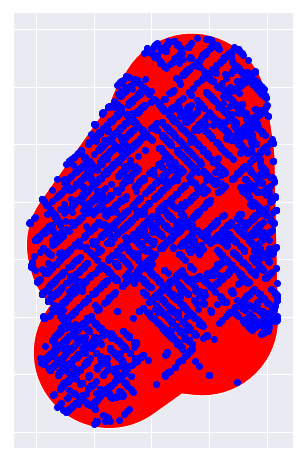

In [12]:
fig, ax = plt.subplots()
remediations_buffer.plot(ax=ax, color='red', markersize=5)
three_one_one_clip.plot(ax=ax, color='blue')
# Remove spines
sns.despine(left=False, bottom=False)
# Remove axes tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

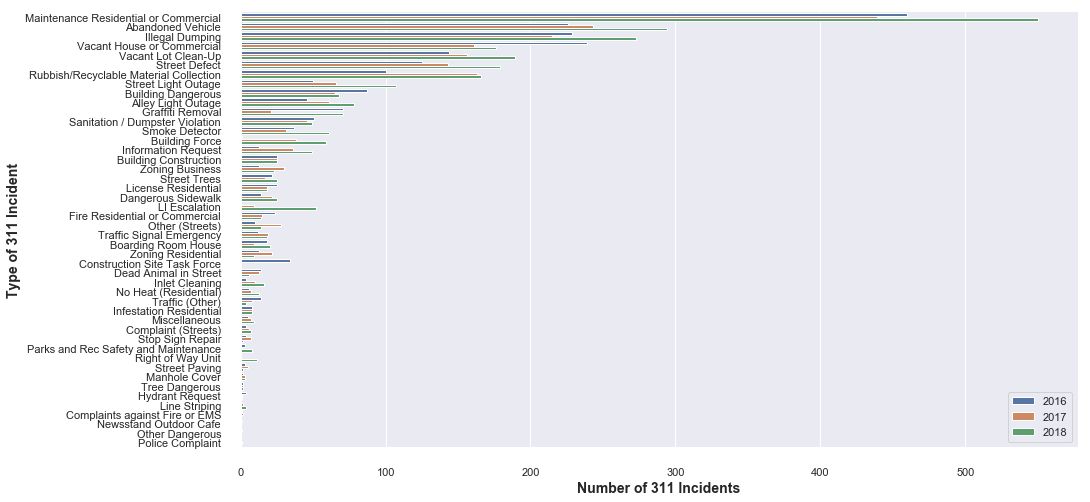

In [13]:
# create a countplot
sns.countplot(y='SERVICE_NAME', 
              hue='YEAR',
              data=three_one_one_clip,
              order=three_one_one_clip['SERVICE_NAME'].value_counts().index)

plt.xlabel('Number of 311 Incidents', size=14, weight='bold')
plt.ylabel('Type of 311 Incident', size=14, weight='bold')

# Remove the top and down margin
sns.despine(offset=10, trim=True)

plt.legend(loc='lower right')

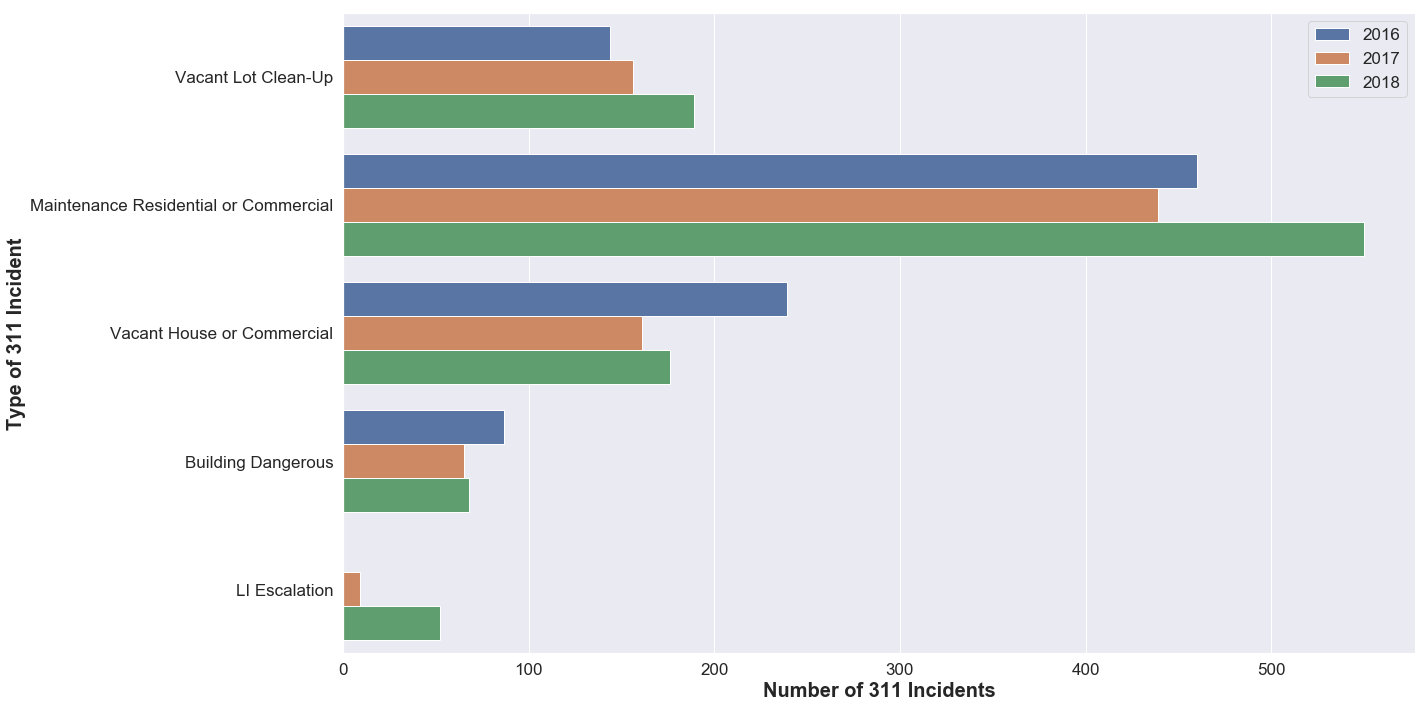

In [17]:
incident_types = [
    'Maintenance Residential or Commercial', 
    'Vacant House or Commercial', 
    'Vacant Lot Clean-Up', 
    'Building Dangerous',
    'Graffeti Removal',
    'LI Escalation'
]

sns.set(rc={'figure.figsize':(20, 10)})

sns.countplot(y='SERVICE_NAME', 
              hue='YEAR',
              data=three_one_one_clip.loc[three_one_one_clip['SERVICE_NAME'].isin(incident_types)])
plt.xlabel('Number of 311 Incidents', size=20, weight='bold')
plt.ylabel('Type of 311 Incident', size=20, weight='bold')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)
plt.tight_layout()
plt.savefig('../figures/311_by_type_specific_clipped.svg')

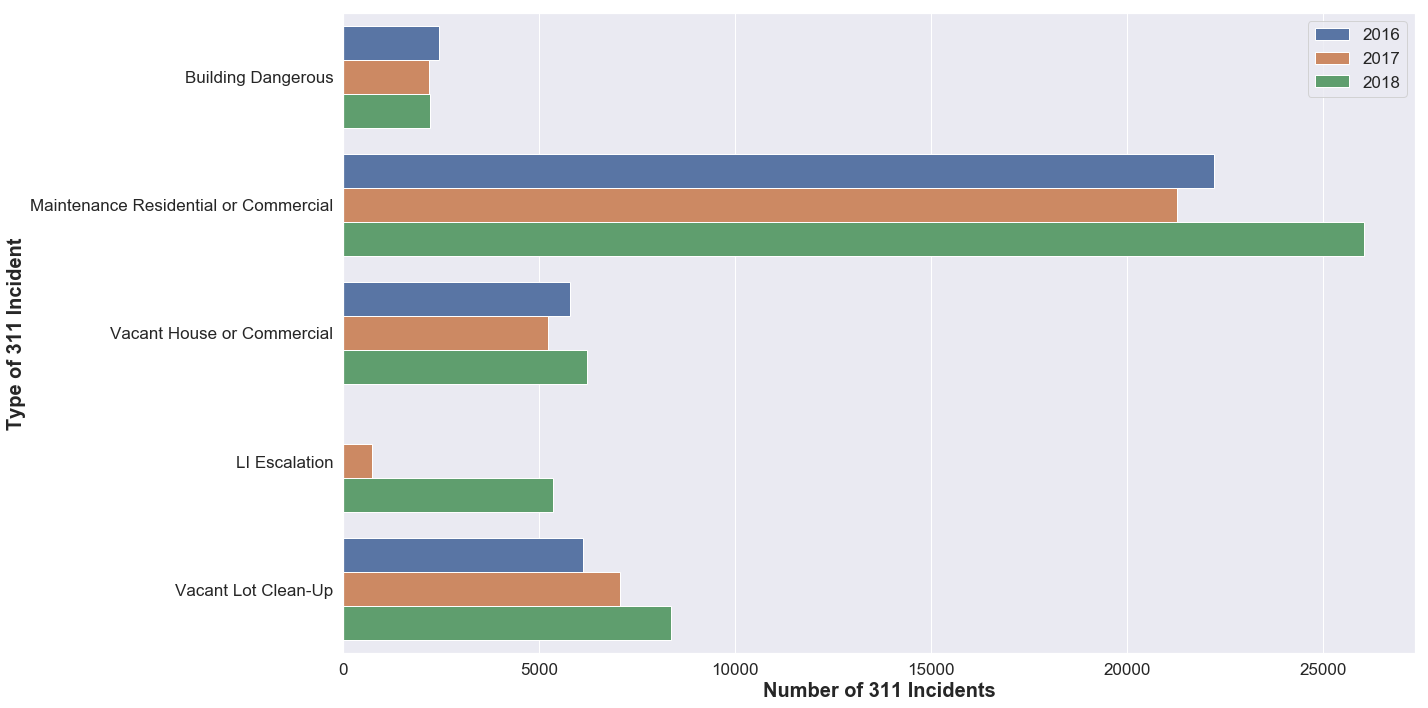

In [20]:
incident_types = [
    'Maintenance Residential or Commercial', 
    'Vacant House or Commercial', 
    'Vacant Lot Clean-Up', 
    'Building Dangerous',
    'Graffeti Removal',
    'LI Escalation'
]

sns.set(rc={'figure.figsize':(20, 10)})

sns.countplot(y='SERVICE_NAME', 
              hue='YEAR',
              data=three_one_one.loc[three_one_one['SERVICE_NAME'].isin(incident_types)])
plt.xlabel('Number of 311 Incidents', size=20, weight='bold')
plt.ylabel('Type of 311 Incident', size=20, weight='bold')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)
plt.tight_layout()
plt.savefig('../figures/311_by_type_specific_entire_city.svg')

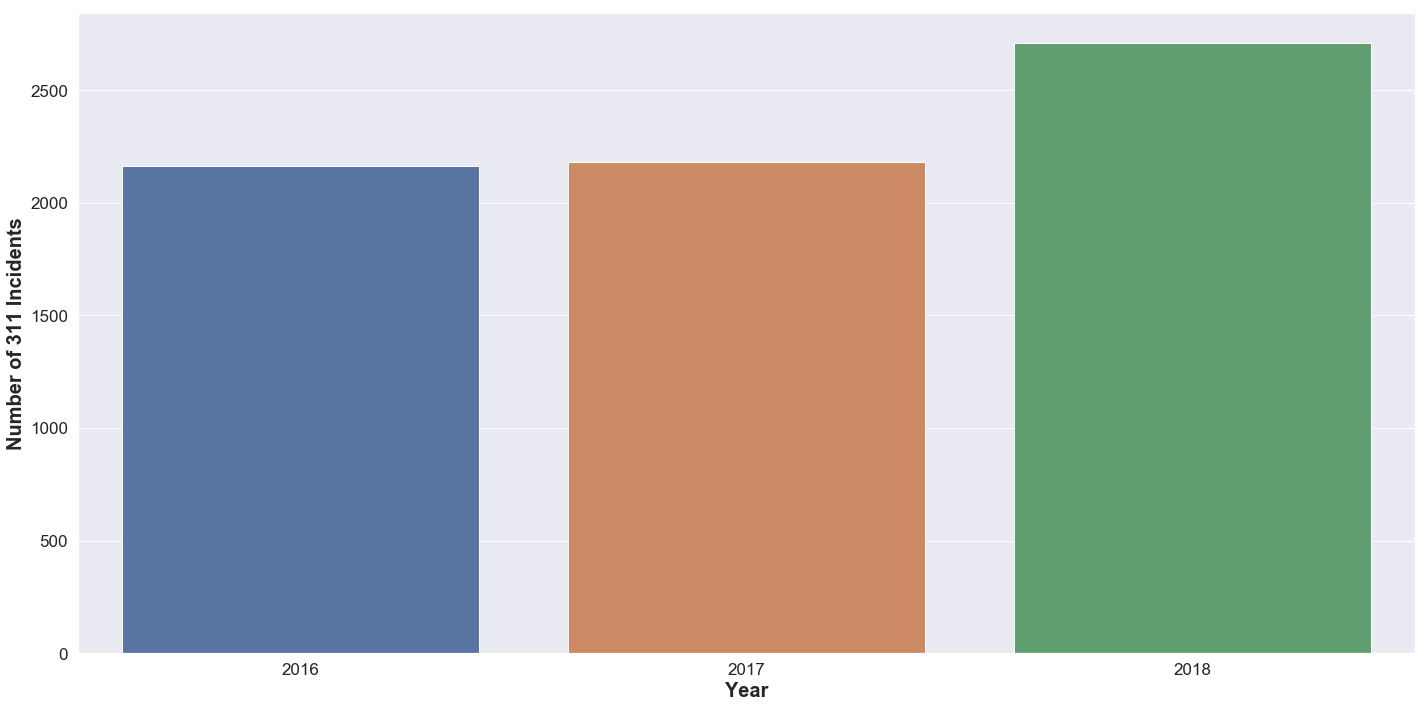

In [22]:
ax = sns.countplot(x='YEAR', 
                   data=three_one_one_clip)
plt.xlabel('Year', size=20, weight='bold')
plt.ylabel('Number of 311 Incidents', size=20, weight='bold')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.savefig('../figures/311_by_year_clipped.svg')

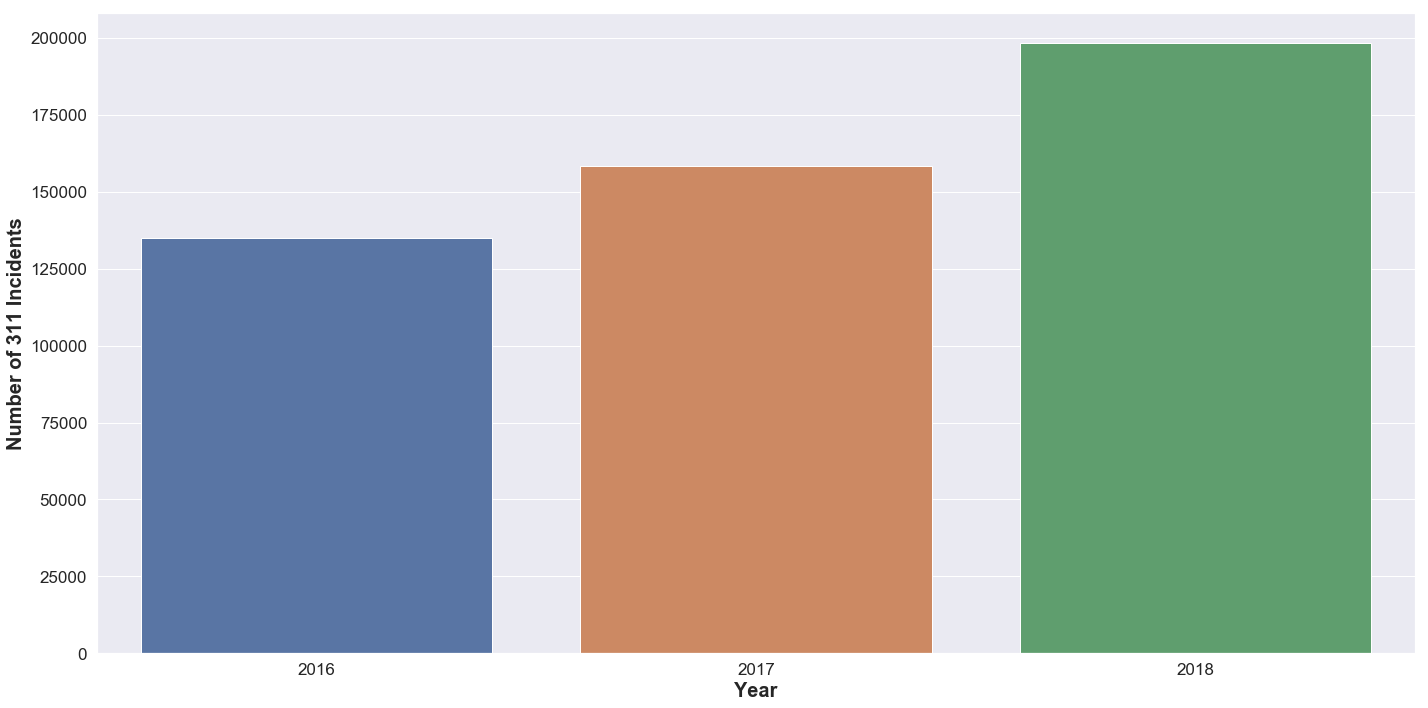

In [23]:
ax = sns.countplot(x='YEAR', 
                   data=three_one_one)
plt.xlabel('Year', size=20, weight='bold')
plt.ylabel('Number of 311 Incidents', size=20, weight='bold')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.savefig('../figures/311_by_year_entire_city.svg')